<xarray.DataArray (time: 48, y: 1237, x: 1661)> Size: 789MB
array([[[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    

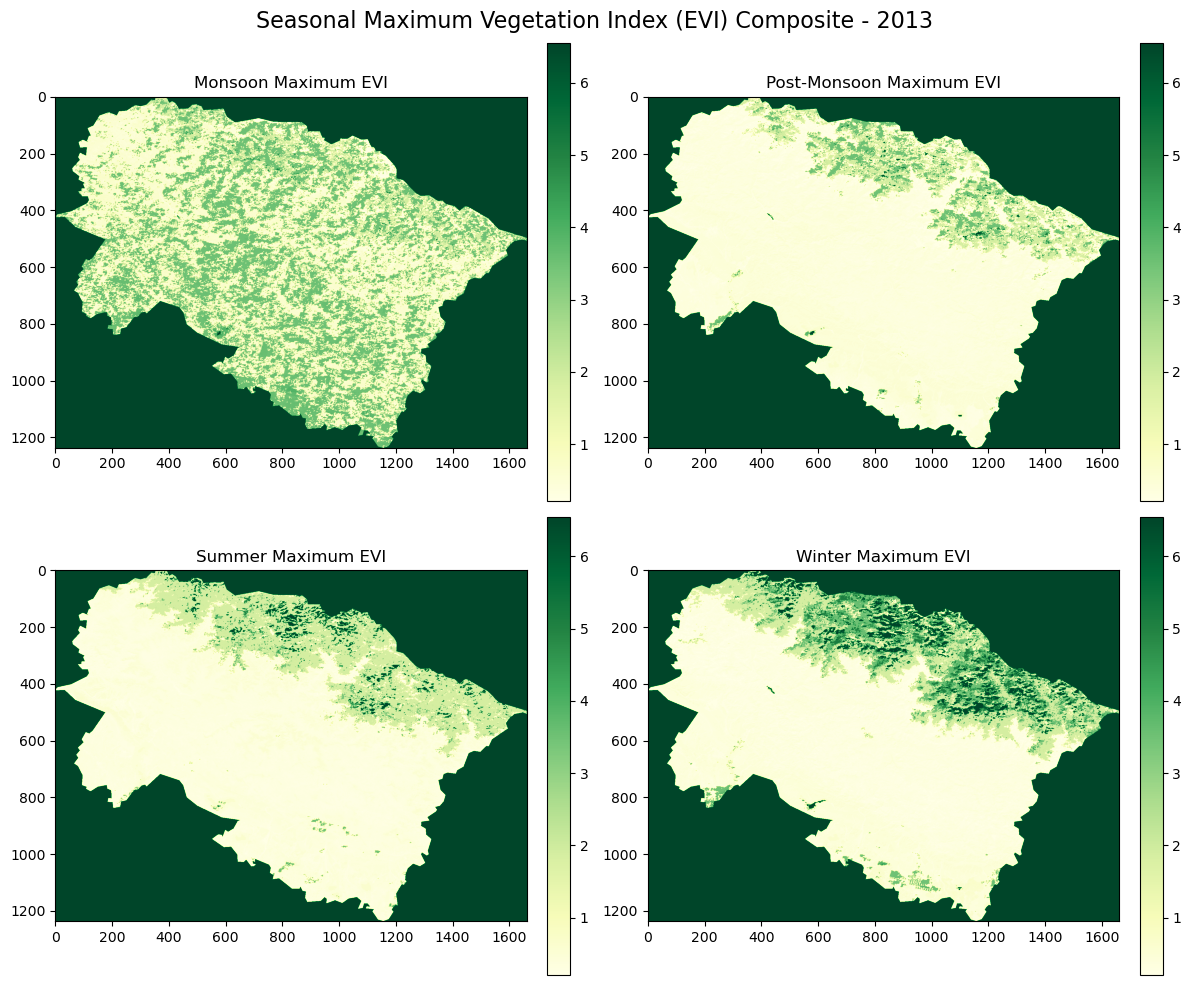

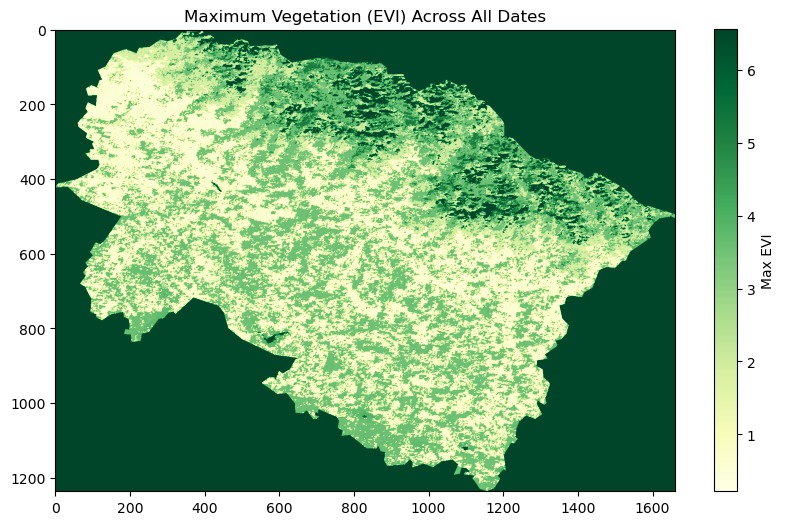

Overall Mean EVI Value: 2.1604615678096137


In [ ]:
import rioxarray
import xarray as xr
import matplotlib.pyplot as plt
import glob
import pandas as pd

files = sorted(glob.glob("*.tif"))
datasets = []
for f in files:
    # Extract date from filename (example: doy2008361 -> 2008-12-26)
    doy = int(f.split('doy')[1][:7])
    year = doy // 1000
    day_of_year = doy % 1000
    date = pd.to_datetime(f"{year}-01-01") + pd.to_timedelta(day_of_year - 1, unit="D")

    da = rioxarray.open_rasterio(f).squeeze()
    evi = da * 0.0001
    nodata_scaled = -3000 * 0.0001
    evi = evi.where(evi != nodata_scaled)
    evi = evi.assign_coords(time=date)
    datasets.append(evi)

evi_all = xr.concat(datasets, dim="time")
print(evi_all)

def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Summer"
    elif month in [6, 7, 8, 9]:
        return "Monsoon"
    else:
        return "Post-Monsoon"
seasons = [get_season(pd.to_datetime(t.item()).month) for t in evi_all.time]
evi_all.coords["season"] = ("time", seasons)

seasonal_evi = evi_all.groupby("season").max(dim="time")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, season in enumerate(seasonal_evi.season.values):
    im = axes[i].imshow(seasonal_evi.sel(season=season), cmap="YlGn", origin="upper")
    axes[i].set_title(f"{season} Maximum EVI")
    plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

plt.suptitle("Seasonal Maximum Vegetation Index (EVI) Composite - 2013", fontsize=16)
plt.tight_layout()
plt.show()


max_evi = evi_all.max(dim="time")

plt.figure(figsize=(10, 6))
plt.imshow(max_evi, cmap="YlGn", origin="upper")
plt.colorbar(label="Max EVI")
plt.title("Maximum Vegetation (EVI) Across All Dates")
plt.show()

# print("Overall Max EVI Value:", float(max_evi.max().item()))
print("Overall Mean EVI Value:", float(evi_all.mean().item()))